In [ ]:
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Final project PTTK/VIB Historical Data.csv')
df.head()
df['Date'] = pd.to_datetime(df['Date'])
train_dates = pd.to_datetime(df['Date'])

df = df.dropna()
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1488 non-null   datetime64[ns]
 1   Price   1488 non-null   int64         
 2   Open    1488 non-null   int64         
 3   High    1488 non-null   int64         
 4   Low     1488 non-null   int64         
 5   Vol.    1488 non-null   float64       
 6   Change  1488 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 81.5 KB


,Date,Price,Open,High,Low,Vol.,Change
0,2017-01-10,8419,8599,8599,8329,484450.0,0.0108
1,2017-01-11,8329,8419,8419,8239,357630.0,-0.0107
2,2017-01-12,7564,8104,8104,7564,107940.0,-0.0918
3,2017-01-13,6843,7339,7339,6798,145860.0,-0.0953
4,2017-01-16,6888,6933,6933,6708,277200.0,0.0066


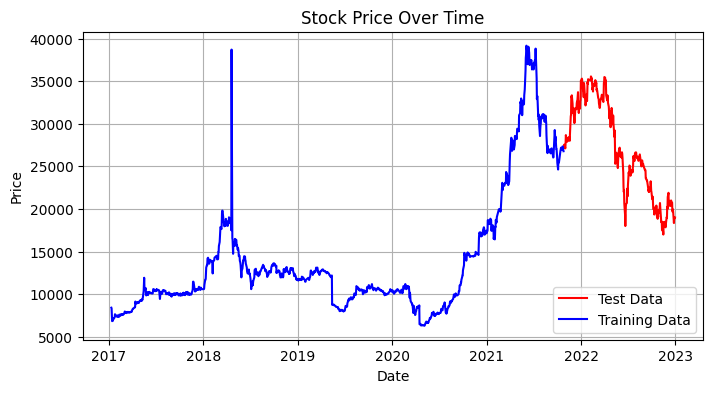

In [ ]:
# Split data into training (80%) and test (20%)
np.random.seed(42)
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

Train_data = train_data
Test_data = test_data
# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(test_data['Date'], test_data['Price'], linestyle='-',  color='r', label='Test Data')
plt.plot(train_data['Date'], train_data['Price'], linestyle='-', color='b', label='Training Data')

plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
cols = list(df)[1:6]
train_data = train_data[cols].astype(float)
test_data = test_data[cols].astype(float)


scaler = StandardScaler()
scaler = scaler.fit(train_data)
df_for_training_scalered = scaler.transform(train_data)


trainX = []
trainY = []

n_past = 14
n_future = 1


for i in range(n_past, len(df_for_training_scalered) - n_future + 1):
    past_sequence = df_for_training_scalered[i - n_past:i, 0:df_for_training_scalered.shape[1]]

    future_sequence = df_for_training_scalered[i + n_future - 1: i + n_future, 0]

    trainX.append(past_sequence)
    trainY.append(future_sequence)

trainX, trainY = np.array(trainX), np.array(trainY)


In [ ]:
print(trainX)

[[[-0.77254753 -0.7463857  -0.76145201 -0.77027177 -0.47080558]
  [-0.78508491 -0.77144087 -0.78603404 -0.78305603 -0.5612044 ]
  [-0.89165269 -0.81528743 -0.82905259 -0.87893794 -0.73918643]
  ...
  [-0.885384   -0.88418916 -0.89665317 -0.87254581 -0.81376082]
  [-0.92299616 -0.88418916 -0.89665317 -0.92382488 -0.80170717]
  [-0.89792139 -0.9344387  -0.89665317 -0.92382488 -0.8045299 ]]

 [[-0.78508491 -0.77144087 -0.78603404 -0.78305603 -0.5612044 ]
  [-0.89165269 -0.81528743 -0.82905259 -0.87893794 -0.73918643]
  [-0.99209109 -0.92177192 -0.93352621 -0.98774615 -0.7121566 ]
  ...
  [-0.92299616 -0.88418916 -0.89665317 -0.92382488 -0.80170717]
  [-0.89792139 -0.9344387  -0.89665317 -0.92382488 -0.8045299 ]
  [-0.91045877 -0.90298054 -0.91508969 -0.89811432 -0.70587672]]

 [[-0.89165269 -0.81528743 -0.82905259 -0.87893794 -0.73918643]
  [-0.99209109 -0.92177192 -0.93352621 -0.98774615 -0.7121566 ]
  [-0.98582239 -0.97828526 -0.98897235 -1.00053041 -0.61853587]
  ...
  [-0.89792139 -0.

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train_data)
df_for_testing_scalered = scaler.transform(test_data)

testX = []
testY = []

for i in range(n_past, len(df_for_testing_scalered) - n_future + 1):
    past_sequence = df_for_testing_scalered[i - n_past:i, 0:df_for_testing_scalered.shape[1]]

    future_sequence = df_for_testing_scalered[i + n_future - 1: i + n_future, 0]

    testX.append(past_sequence)
    testY.append(future_sequence)

testX, testY = np.array(testX), np.array(testY)


In [ ]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('trainX shape == {}.'.format(testX.shape))
print('trainY shape == {}.'.format(testY.shape))


trainX shape == (1176, 14, 5).
trainY shape == (1176, 1).
trainX shape == (284, 14, 5).
trainY shape == (284, 1).


In [ ]:
# ------------------------- MODEL LSTM ---------------------

#Tạo model lstm cho việc training
# model = Sequential()
# model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(LSTM(32, activation='relu', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(trainY.shape[1]))
# model.compile(optimizer='adam', loss='mse')
# model.summary()


# # ----------------------MODEL CNN LSTM --------------------
from keras.models import Sequential
from keras.layers import ConvLSTM2D, LSTM, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dropout, Dense

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 12, 32)            512       
                                                                 
 lstm_8 (LSTM)               (None, 12, 64)            24832     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 37793 (147.63 KB)
Trainable params: 37793 (147.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=4, validation_split=0.1, verbose=1)

Epoch 1/50
265/265 [==============================] - 17s 27ms/step - loss: 0.0762 - val_loss: 0.5266
Epoch 2/50
265/265 [==============================] - 5s 18ms/step - loss: 0.0393 - val_loss: 0.2420
Epoch 3/50
265/265 [==============================] - 4s 14ms/step - loss: 0.0384 - val_loss: 0.1257
Epoch 4/50
265/265 [==============================] - 3s 11ms/step - loss: 0.0343 - val_loss: 0.1142
Epoch 5/50
265/265 [==============================] - 3s 11ms/step - loss: 0.0348 - val_loss: 0.2183
Epoch 6/50
265/265 [==============================] - 3s 13ms/step - loss: 0.0315 - val_loss: 0.8442
Epoch 7/50
265/265 [==============================] - 5s 19ms/step - loss: 0.0354 - val_loss: 0.5254
Epoch 8/50
265/265 [==============================] - 3s 12ms/step - loss: 0.0318 - val_loss: 1.6991
Epoch 9/50
265/265 [==============================] - 3s 11ms/step - loss: 0.0320 - val_loss: 0.2832
Epoch 10/50
265/265 [==============================] - 3s 11ms/step - loss: 0.0239 - val_l

In [ ]:
prediction = model.predict(testX)

prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


9/9 [==============================] - 0s 5ms/step


In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
#us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 15
n_days_for_prediction= 30

predict_period_dates = pd.date_range(list(train_dates)[-1], periods=n_days_for_prediction).tolist()
print(predict_period_dates)

#Make prediction
prediction1 = model.predict(testX[-n_days_for_prediction:])
df_for_training = df[cols].astype(float)

prediction_copies1 = np.repeat(prediction1, df_for_training.shape[1], axis=-1)
y_pred_future1 = scaler.inverse_transform(prediction_copies1)[:,0]

print(len(y_pred_future1))

[Timestamp('2022-12-30 00:00:00', freq='D'), Timestamp('2022-12-31 00:00:00', freq='D'), Timestamp('2023-01-01 00:00:00', freq='D'), Timestamp('2023-01-02 00:00:00', freq='D'), Timestamp('2023-01-03 00:00:00', freq='D'), Timestamp('2023-01-04 00:00:00', freq='D'), Timestamp('2023-01-05 00:00:00', freq='D'), Timestamp('2023-01-06 00:00:00', freq='D'), Timestamp('2023-01-07 00:00:00', freq='D'), Timestamp('2023-01-08 00:00:00', freq='D'), Timestamp('2023-01-09 00:00:00', freq='D'), Timestamp('2023-01-10 00:00:00', freq='D'), Timestamp('2023-01-11 00:00:00', freq='D'), Timestamp('2023-01-12 00:00:00', freq='D'), Timestamp('2023-01-13 00:00:00', freq='D'), Timestamp('2023-01-14 00:00:00', freq='D'), Timestamp('2023-01-15 00:00:00', freq='D'), Timestamp('2023-01-16 00:00:00', freq='D'), Timestamp('2023-01-17 00:00:00', freq='D'), Timestamp('2023-01-18 00:00:00', freq='D'), Timestamp('2023-01-19 00:00:00', freq='D'), Timestamp('2023-01-20 00:00:00', freq='D'), Timestamp('2023-01-21 00:00:00'

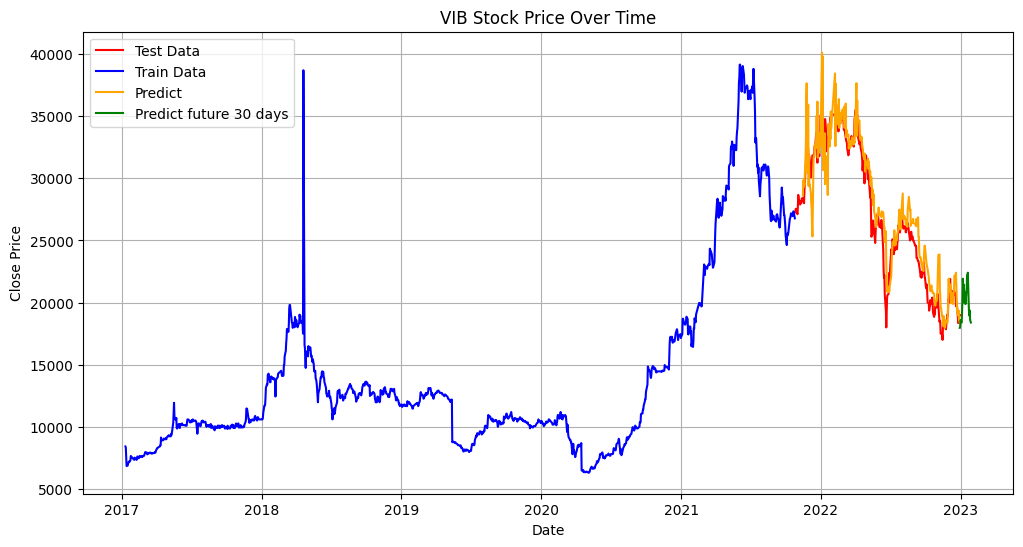

In [ ]:
#y_pred = model.predict(testX)

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(Test_data['Date'],Test_data['Price'], linestyle='-',  color='r', label='Test Data')
plt.plot(Train_data['Date'], Train_data['Price'], linestyle='-', color='b', label='Train Data')
predict_date = Test_data['Date'];
plt.plot(predict_date[14:],  y_pred_future, label='Predict', linestyle='-',  color='orange')
plt.plot(predict_period_dates, y_pred_future1, label='Predict future 30 days', linestyle='-',  color='green')

plt.title('VIB Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred_future_flat = y_pred_future.flatten()

rmse = np.sqrt(mean_squared_error(Test_data['Price'].iloc[14:], y_pred_future_flat))

mae = mean_absolute_error(Test_data['Price'].iloc[14:], y_pred_future_flat)

mape = np.mean(np.abs((Test_data['Price'].iloc[14:] - y_pred_future_flat) / Test_data['Price'].iloc[14:]))*100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")


RMSE: 1845.3595567385198
MAE: 1371.1078895246478
MAPE: 5.357518341494143
